In [0]:
# imports 
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd



In [0]:
class BeerFermentationModel:
    """
    Beer fermentation model based on biomass dynamics (Section 3.4.1).
    
    This model describes fermentation through:
    - Biomass growth with Droop-like kinetics
    - Sugar consumption
    - Ethanol production
    - CO2 generation
    - VDK production and reduction
    """
    
    def __init__(self, params):
        """
        Initialize model parameters.
        
        Args:
            params: Dictionary containing stoichiometric coefficients,
                   kinetic parameters, and temperature-dependency parameters
        """
        self.params = params
    
    def calculate_specific_growth_rate(self, sugar, s_min, mu_max):
        """
        Calculate specific growth rate using Droop-like kinetics (Eq. 27).
        
        Args:
            sugar: Current sugar concentration (g/L)
            s_min: Minimum sugar quota (g/L)
            mu_max: Maximum specific growth rate (h^-1)
            
        Returns:
            Specific growth rate (h^-1)
        """
        if sugar >= s_min:
            return mu_max * (1 - s_min / sugar)
        else:
            return 0.0
    
    def temperature_dependency(self, temperature):
        """
        Calculate temperature-dependent parameters (Eq. 37).
        
        Args:
            temperature: Temperature (°C)
            
        Returns:
            Tuple of (mu_max, r_vdk)
        """
        params = self.params
        
        # mu_max = a * ln(T) + b
        mu_max = params['a'] * np.log(temperature) + params['b']
        
        # r_vdk = c * ln(T) + d
        r_vdk = params['c'] * np.log(temperature) + params['d']
        
        return mu_max, r_vdk
    
    def derivatives(self, state, time_point, temperature):
        """
        System of ODEs for beer fermentation (Equations 26a-26e).
        
        Args:
            state: [X, S, E, CO2, VDK]
            time_point: Current time value
            temperature: Temperature (°C)
            
        Returns:
            List of derivatives for each state variable
        """
        biomass, sugar, ethanol, co2, vdk = state
        params = self.params
        
        # Get temperature-dependent parameters
        mu_max, r_vdk = self.temperature_dependency(temperature)
        
        # Calculate specific growth rate (Eq. 27)
        mu_x = self.calculate_specific_growth_rate(sugar, params['S_min'], 
                                                   mu_max)
        
        # ODEs (Equations 26a-26e)
        # Biomass (26a)
        dx_dt = mu_x * biomass - params['delta_x'] * biomass
        
        # Sugar (26b)
        ds_dt = -params['k_s'] * mu_x * biomass
        
        # Ethanol (26c)
        de_dt = params['k_e'] * mu_x * biomass
        
        # CO2 (26d)
        dco2_dt = params['k_co2'] * mu_x * biomass
        
        # VDK (26e)
        dvdk_dt = params['k_v'] * mu_x * biomass - r_vdk * vdk
        
        return [dx_dt, ds_dt, de_dt, dco2_dt, dvdk_dt]
    
    def simulate(self, initial_state, time_span, temperature):
        """
        Simulate the fermentation process
        
        Args:
            initial_state: [X0, S0, E0, CO20, VDK0]
            time_span: Array of time points
            temperature: Temperature (°C, constant or array)
            
        Returns:
            Array of state variables at each time point
        """
        solution = odeint(self.derivatives, initial_state, time_span, 
                         args=(temperature,))
        return solution



In [0]:

def plot_results(time_points, x_result, s_result, e_result, co2_result, 
                vdk_result, temperature):
    """
    Plot fermentation results.
    
    Args:
        time_points: Array of time values
        x_result: Biomass concentration array
        s_result: Sugar concentration array
        e_result: Ethanol concentration array
        co2_result: CO2 volume array
        vdk_result: VDK concentration array
        temperature: Temperature (°C)
    """
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    title_text = (f'Beer Fermentation Simulation - 1500L Fermenter\n'
                  f'Temperature: {temperature:.1f}°C')
    fig.suptitle(title_text, fontsize=14, fontweight='bold')
    
    # Sugar
    axes[0, 0].plot(time_points, s_result, 'b-', linewidth=2)
    axes[0, 0].set_ylabel('Sugar (g/L)', fontsize=11)
    axes[0, 0].set_xlabel('Time (h)', fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_title('Sugar Consumption')
    
    # Ethanol
    axes[0, 1].plot(time_points, e_result, 'r-', linewidth=2)
    axes[0, 1].set_ylabel('Ethanol (g/L)', fontsize=11)
    axes[0, 1].set_xlabel('Time (h)', fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_title('Ethanol Production')
    
    # Biomass
    axes[0, 2].plot(time_points, x_result, 'g-', linewidth=2)
    axes[0, 2].set_ylabel('Biomass (g/L)', fontsize=11)
    axes[0, 2].set_xlabel('Time (h)', fontsize=11)
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].set_title('Biomass Growth')
    
    # CO2
    axes[1, 0].plot(time_points, co2_result, 'c-', linewidth=2)
    axes[1, 0].set_ylabel('CO₂ (L)', fontsize=11)
    axes[1, 0].set_xlabel('Time (h)', fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_title('CO₂ Production')
    
    # VDK
    axes[1, 1].plot(time_points, vdk_result, 'm-', linewidth=2)
    axes[1, 1].set_ylabel('VDK (ppm)', fontsize=11)
    axes[1, 1].set_xlabel('Time (h)', fontsize=11)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_title('Vicinal Diketones')
    
    # Sugar vs Ethanol phase plot
    axes[1, 2].plot(s_result, e_result, 'k-', linewidth=2)
    axes[1, 2].scatter([s_result[0]], [e_result[0]], c='green', s=100, 
                       marker='o', label='Start', zorder=5)
    axes[1, 2].scatter([s_result[-1]], [e_result[-1]], c='red', s=100, 
                       marker='s', label='End', zorder=5)
    axes[1, 2].set_xlabel('Sugar (g/L)', fontsize=11)
    axes[1, 2].set_ylabel('Ethanol (g/L)', fontsize=11)
    axes[1, 2].set_title('Phase Plot')
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()


In [0]:


def main():
    """Run beer fermentation simulation - 30L baseline."""
    
    # Parameters from Table 5
    params = {
        'k_s': 15.3,        # Sugar yield coefficient (g_S/g_X)
        'k_e': 6.31,        # Ethanol yield coefficient (g_E/g_X)
        'k_co2': 37.1,      # CO2 yield coefficient (L/g_X)
        'k_v': 0.651,       # VDK yield coefficient (g_VDK/g_X)
        'S_min': 13.1,      # Minimum sugar quota (g/L)
        'delta_x': 0.0167,  # Settling/death constant (h^-1)
        'a': 0.400,         # Temperature coefficient (mu_max)
        'b': -1.1,          # Temperature coefficient (mu_max)
        'c': 0.0250,        # Temperature coefficient (r_vdk)
        'd': -0.0560,       # Temperature coefficient (r_vdk)
    }
    
    # Vessel volume (30L baseline)
    volume = 1200  # L
    
    # Initial conditions
    x0 = 0.004          # Initial biomass (g/L)
    s0 = 124.83         # Initial sugar (g/L)
    e0 = 0.0            # Initial ethanol (g/L)
    co2_0 = 0.0         # Initial CO2 (L)
    vdk0 = 0.0          # Initial VDK (ppm)
    
    initial_state = [x0, s0, e0, co2_0, vdk0]
    
    # Simulation parameters
    duration = 336       # hours
    time_points = np.linspace(0, duration, 300)
    temperature = 19.0  # °C
    
    # Run simulation
    model = BeerFermentationModel(params)
    solution = model.simulate(initial_state, time_points, temperature)
    
    # Extract results
    x_result, s_result, e_result, co2_result, vdk_result = solution.T
    
    # Create summary table
    summary_data = {
        'Parameter': [
            'Fermenter Volume',
            'Temperature',
            'Duration',
            '',
            'Initial Biomass',
            'Final Biomass',
            'Biomass Change',
            '',
            'Initial Sugar',
            'Final Sugar',
            'Sugar Consumed',
            'Sugar Consumed %',
            '',
            'Initial Ethanol',
            'Final Ethanol',
            '',
            'Initial CO2',
            'Final CO2',
            '',
            'Initial VDK',
            'Final VDK',
            '',
            'Estimated ABV',
            'Total Biomass',
            'Total Ethanol'
        ],
        'Value': [
            f"{volume:.1f} L",
            f"{temperature:.1f} °C",
            f"{time_points[-1]:.0f} hours",
            '',
            f"{x0:.3f} g/L",
            f"{x_result[-1]:.3f} g/L",
            f"{((x_result[-1]/x0)-1)*100:+.1f}%",
            '',
            f"{s0:.1f} g/L",
            f"{s_result[-1]:.1f} g/L",
            f"{s0 - s_result[-1]:.1f} g/L",
            f"{((s0-s_result[-1])/s0)*100:.1f}%",
            '',
            f"{e0:.1f} g/L",
            f"{e_result[-1]:.1f} g/L",
            '',
            f"{co2_0:.1f} L",
            f"{co2_result[-1]:.1f} L",
            '',
            f"{vdk0:.2f} ppm",
            f"{vdk_result[-1]:.4f} ppm",
            '',
            f"~{(e_result[-1] * 0.789 / 10):.1f}%",
            f"{x_result[-1] * volume:.1f} g",
            f"{e_result[-1] * volume:.1f} g"
        ]
    }
    
    results_df = pd.DataFrame(summary_data)
    
    # Time series dataframe
    timeseries_df = pd.DataFrame({
        'Time (h)': time_points,
        'Biomass (g/L)': x_result,
        'Sugar (g/L)': s_result,
        'Ethanol (g/L)': e_result,
        'CO2 (L)': co2_result,
        'VDK (ppm)': vdk_result
    })
    
    # Return results
    return {
        'time': time_points,
        'biomass': x_result,
        'sugar': s_result,
        'ethanol': e_result,
        'co2': co2_result,
        'vdk': vdk_result,
        'volume': volume,
        'temperature': temperature,
        'summary_table': results_df,
        'timeseries_table': timeseries_df
    }



FERMENTATION SIMULATION RESULTS (30L Baseline)


Parameter,Value
Fermenter Volume,1200.0 L
Temperature,19.0 °C
Duration,336 hours
,
Initial Biomass,0.004 g/L
Final Biomass,0.209 g/L
Biomass Change,+5113.4%
,
Initial Sugar,124.8 g/L
Final Sugar,13.1 g/L


TIME SERIES DATA (First 10 rows)


Time (h),Biomass (g/L),Sugar (g/L),Ethanol (g/L),CO2 (L),VDK (ppm)
0.0,0.004,124.83,0.0,0.0,0.0
1.1237458193979932,0.004245058541277904,124.82506725849365,0.002034352869617434,0.011961092149414708,2.078405148695271E-4
2.2474916387959865,0.004505128981049756,124.81983233715725,0.004193330231230096,0.02465492101087743,4.2434052978270506E-4
3.3712374581939795,0.0047811304059250615,124.81427673437378,0.006484562490293219,0.038126349982548095,6.50109978075117E-4
4.494983277591973,0.005074038686433721,124.80838080531423,0.00891615153380962,0.05242301456487115,8.857949028865954E-4
5.618729096989966,0.005384889125824726,124.80212370859348,0.011496692730399527,0.06759545171122383,0.0011320791687191812
6.742474916387959,0.0057147805783802135,124.7954833233383,0.014235309133030671,0.08369730092479206,0.0013896871122510675
7.866220735785952,0.0060648788215756505,124.78843618127681,0.017141679486492242,0.1007854689300891,0.0016593857161739138
8.989966555183946,0.006436421144612919,124.78095737432966,0.02022607633854764,0.11892035374962245,0.0019419875655523149
10.113712374581938,0.006830720901891343,124.77302046290511,0.02349940386069919,0.13816606707320764,0.0022383537810675967


TIME SERIES DATA (Last 10 rows)


Time (h),Biomass (g/L),Sugar (g/L),Ethanol (g/L),CO2 (L),VDK (ppm)
325.88628762541805,0.24690443558450345,13.100000000176665,46.079496731953284,270.92699346362394,0.13392393056951507
327.01003344481603,0.24231409626147993,13.100000000177591,46.07949673195291,270.9269934636217,0.13129959450786574
328.133779264214,0.2378090985488851,13.10000000017787,46.07949673195279,270.92699346362105,0.12872668422700997
329.257525083612,0.23338785608894355,13.10000000017622,46.07949673195347,270.926993463625,0.12620419222212093
330.38127090301003,0.22904881185012493,13.100000000171985,46.07949673195522,270.9269934636353,0.12373113059857399
331.505016722408,0.22479043702888296,13.100000000167036,46.079496731957256,270.9269934636473,0.12130653024664459
332.628762541806,0.22061123185513587,13.10000000016133,46.07949673195961,270.9269934636611,0.11892944153316558
333.752508361204,0.2165097244440019,13.100000000155054,46.0794967319622,270.92699346367635,0.11659893343524186
334.87625418060196,0.21248447032726153,13.100000000148562,46.07949673196487,270.9269934636921,0.11431409321523092
336.0,0.20853405196096209,13.100000000142403,46.07949673196742,270.926993463707,0.11207402607614383


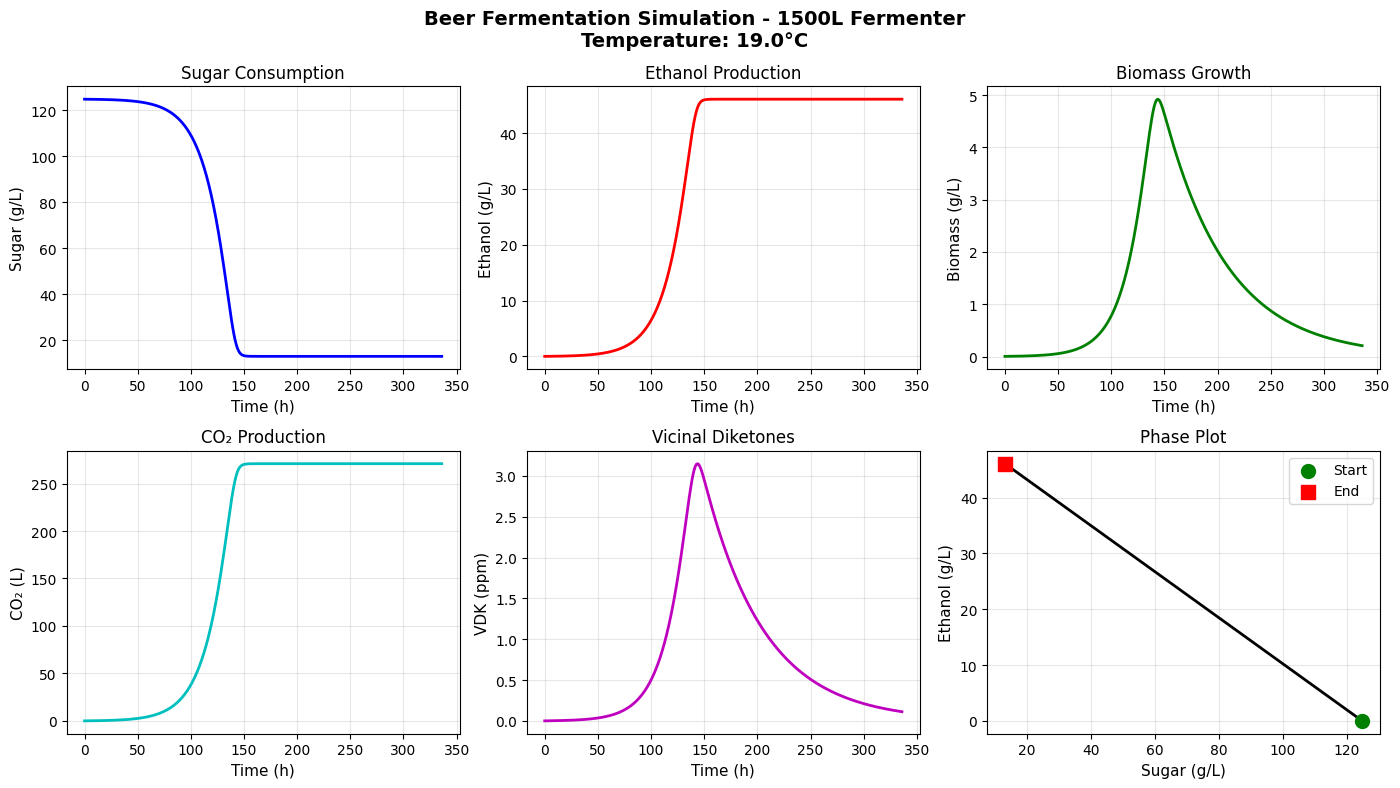

In [0]:

if __name__ == "__main__":
    # Run simulation
    results = main()
    
    # Display results
    print("FERMENTATION SIMULATION RESULTS (30L Baseline)")
    display(results['summary_table'])
    
    print("TIME SERIES DATA (First 10 rows)")
    display(results['timeseries_table'].head(10))
    
    print("TIME SERIES DATA (Last 10 rows)")
    display(results['timeseries_table'].tail(10))
    
    # Plot results
    plot_results(
        results['time'],
        results['biomass'],
        results['sugar'],
        results['ethanol'],
        results['co2'],
        results['vdk'],
        results['temperature']
    )